# 简易回归教程

[]()

# 第一部分：多项式回归

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from caffe2.python import workspace, brew, optimizer
from caffe2.python.model_helper import ModelHelper
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.preprocessing import PolynomialFeatures

## 输入
指定回归模型是输入参数：输入样本点的个数，训练迭代的次数，SGD算法的学习率和模型的初始化权重。

In [2]:
# Number of training sample to generate
num_samples = 200
# Learning Rate of SGD algorithm
learning_rate = .05
# Number of iterations to train
training_iters = 100
# Initial model weights
initial_weights = [0.,0.]

## 创建并准备数据集

现在，我们创建数据，准备用于训练的数据集。注意，我们只是在这里构建Numpy数组。可以使用任何其他数据，只要它在输入模型之前给予正确的形状。

X Sample:
[[ 0.92298861  0.85190798]
 [-0.22871158  0.05230899]
 [-0.28543417  0.08147267]
 [ 0.49019672  0.24029283]
 [-1.35208998  1.82814732]]
Y Sample:
[[1.46521607]
 [0.41152479]
 [0.78926914]
 [1.00226251]
 [2.25706641]]


Text(0.5,1,u'Input Training Data')

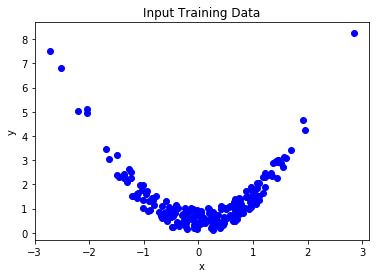

In [3]:
# Create the original observations
orig_X,_ = sklearn.datasets.make_regression(n_samples=num_samples,n_features=1,noise=5)
poly = PolynomialFeatures(degree=2, include_bias=False)
# Transform the features into second order polynomial features
xx_ = poly.fit_transform(orig_X)

# Extract the predictors and the values from the manufactured data
X = [i[0] for i in xx_]
Y_gt = [i[1] for i in xx_]
noise = np.random.uniform(size=(len(Y_gt)))
# Add some noise to the ground truth values
Y_gt += noise

# Shape the ground truth values for use with the model
Y_gt = np.reshape(Y_gt,(-1,1))
# Format the input features. Recall, we accomplish polynomial regression by
#   including the original and the polynomial version of the predictors
#   as features of the model
X = np.hstack((np.array(X).reshape(-1,1),np.array(X).reshape(-1,1)**2))

# Print a sample of the input data. X is the list of 2-feature input observations 
#   and Y is the list of ground truth values associated with each observation
print("X Sample:\n{}".format(X[:5]))
print("Y Sample:\n{}".format(Y_gt[:5]))

# Plot the input data
plt.scatter([i[0] for i in X],Y_gt,label="original data",color='b')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Input Training Data")

## 创建模型

### 定义模型结构



In [4]:
# Create the model helper object we will use to create the regression model
regression_model = ModelHelper(name="regression_model")

# Add the FC layer, which is the main component of a linear regression model
y_pred = brew.fc(regression_model,'X','y_pred', dim_in=2, dim_out=1)

# Print the predict and init net to see what protobuf was created for this model
print("************* Predict Net *************")
print(regression_model.net.Proto())
print("\n************* Init Net *************")
print(regression_model.param_init_net.Proto())

************* Predict Net *************
name: "regression_model"
op {
  input: "X"
  input: "y_pred_w"
  input: "y_pred_b"
  output: "y_pred"
  name: ""
  type: "FC"
  arg {
    name: "use_cudnn"
    i: 1
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
}
external_input: "X"
external_input: "y_pred_w"
external_input: "y_pred_b"


************* Init Net *************
name: "regression_model_init"
op {
  output: "y_pred_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints: 1
    ints: 2
  }
}
op {
  output: "y_pred_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 1
  }
}



### 添加训练阶段的操作并且填充workspace

在这个非常重要的步骤中，我们指定损失函数，设定SGD训练算法，填充并且初始化workspace，初始化模型的权重和偏置。

In [5]:
# The loss function is computed by a squared L2 distance, 
#   and then averaged over all items.
dist = regression_model.SquaredL2Distance(['Y_gt', y_pred], "dist")
loss = regression_model.AveragedLoss(dist, "loss")

# Add the gradient operators and setup the SGD algorithm
regression_model.AddGradientOperators([loss])
optimizer.build_sgd(regression_model, base_learning_rate=learning_rate)

# Prime the workspace with some data
workspace.FeedBlob("Y_gt",Y_gt.astype(np.float32))
workspace.FeedBlob("X",X.astype(np.float32))

# Run the init net to prepare the workspace then create the net
workspace.RunNetOnce(regression_model.param_init_net)
workspace.CreateNet(regression_model.net)

# Inject our desired initial weights and bias
workspace.FeedBlob("y_pred_w",np.array([initial_weights]).astype(np.float32))
workspace.FeedBlob("y_pred_b",np.array([0.]).astype(np.float32))

True

### 执行训练

In [6]:
# Run the training for training_iters
for i in range(training_iters):
    workspace.RunNet(regression_model.net)

print("Training Complete")

Training Complete


## 提取结果


Best Fit Line: 0.99461*x^2 + 0.0179*x + 0.52854


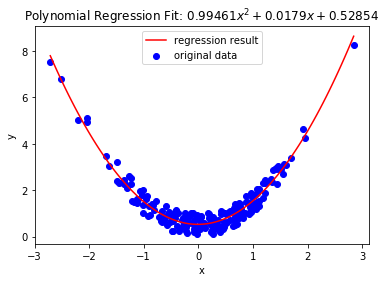

In [7]:

# Extract the learned coes and intercept from the workspace# Extra 
coes = workspace.FetchBlob("y_pred_w")[0]
intercept = workspace.FetchBlob("y_pred_b")

# Calculate the regression line for plotting
x_vals = np.linspace(orig_X.min(), orig_X.max(),100)
regression_result = intercept[0] + coes[0]*x_vals + coes[1]*(x_vals**2)
print("Best Fit Line: {}*x^2 + {}*x + {}".format(round(coes[1],5), round(coes[0],5), round(intercept[0],5)))

# Plot the results of the regression
plt.scatter([i[0] for i in X],Y_gt,label="original data",color='b')
plt.plot(x_vals,regression_result,label="regression result",color='r')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Polynomial Regression Fit: ${{{}}}x^2 + {{{}}}x + {{{}}}$".format(round(coes[1],5), round(coes[0],5), round(intercept[0],5)))
plt.show()

# 第二部分：表达线性回归示例

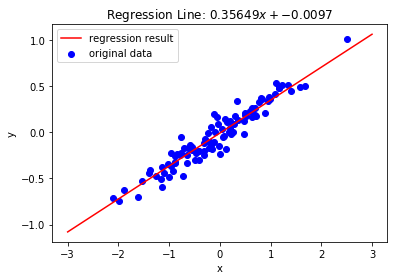

In [8]:
#####################################################################
# Initialize data
#####################################################################
X,Y_gt = sklearn.datasets.make_regression(n_samples=100,n_features=1,noise=10)
Y_gt = np.reshape(Y_gt,(-1,1))
Y_gt /= 100.

#####################################################################
# Create and train model
#####################################################################
# Construct model with single FC layer
regression_model = ModelHelper(name="regression_model")
y_pred = brew.fc(regression_model,'X','y_pred', dim_in=1, dim_out=1)

# Specify Loss function
dist = regression_model.SquaredL2Distance(['Y_gt', y_pred], "dist")
loss = regression_model.AveragedLoss(dist, "loss")

# Get gradients for all the computations above.
regression_model.AddGradientOperators([loss])
optimizer.build_sgd(regression_model, base_learning_rate=0.05)

# Prime and prepare workspace for training
workspace.FeedBlob("Y_gt",Y_gt.astype(np.float32))
workspace.FeedBlob("X",X.astype(np.float32))
workspace.RunNetOnce(regression_model.param_init_net)
workspace.CreateNet(regression_model.net)

# Set the initial weight and bias to 0
workspace.FeedBlob("y_pred_w",np.array([[0.]]).astype(np.float32))
workspace.FeedBlob("y_pred_b",np.array([0.]).astype(np.float32))

# Train the model
for i in range(100):
    workspace.RunNet(regression_model.net)

#####################################################################
# Collect and format results
#####################################################################
# Grab the learned weight and bias from workspace
coe = workspace.FetchBlob("y_pred_w")[0]
intercept = workspace.FetchBlob("y_pred_b")

# Calculate the regression line for plotting
x_vals = range(-3,4)
regression_result = x_vals*coe + intercept

# Plot the results
plt.scatter(X,Y_gt,label="original data",color='b')
plt.plot(x_vals,regression_result,label="regression result",color='r')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression Line: ${{{}}}x + {{{}}}$".format(round(coe,5), round(intercept[0],5)))
plt.show()